In [1]:
import psycopg2
import matplotlib.pyplot as plt
import pandas as pd

# Monthly News Bias Analysis
----------

<strong>Bifocal News</strong><br />
Justin Miller

### Introduction
This report is a descriptive analysis of data collected and displayed for Bifocal News (https://bifocalnews.com). Bifocal News is a website that takes liberal and conservative Reddit communities and compares what each other are talking about. Along the way, Bifocal News collects the interesting data shown in this report.

The goal of this report is to provide a glimpse into the political news trends and hot topics for the month, as well as comparing and contrasting "liberal" and "conservative" discussions and headlines. 

### Keyword Identification Algorithm
The goal of this algorithm is to derive important keywords from an article posted to a subreddit. User posts can be misleading, trolling, and unneccessarily biased so this algorithm only cares about keywords found in the actual article. Below are the general steps:

    - Clean article content by removing useless words and making everything lower case
    - Identify names of individuals, places, and organizations in the content of the article
        - If those names appear in the title of the article, they are keywords
    - Identify non-name keywords from the content of the article
        - If the keyword is in the title, it is a significant keyword

Parsing the title itself for keywords using NLP is often difficult because titles do not need to be complete sentences and identifying significant words becomes much more difficult and inaccurate.



In [2]:
conn = psycopg2.connect("dbname='reddit_data' user='postgres' host='localhost' password='magicalpasswordbifocalnews'")
cur = conn.cursor()

In [25]:
#Get the most popular domains of each news type
cur.execute("""
SELECT count(*), count(CASE WHEN news_type = 'liberal' THEN 1 END), count(CASE WHEN news_type = 'conservative' THEN 1 END), substring(article_url from '.*://([^/]*)')
FROM NewsArticles
WHERE created_utc > extract(epoch from now() - interval '1 month')
GROUP BY substring(article_url from '.*://([^/]*)')
ORDER BY count(*) DESC
""")
result = cur.fetchall()

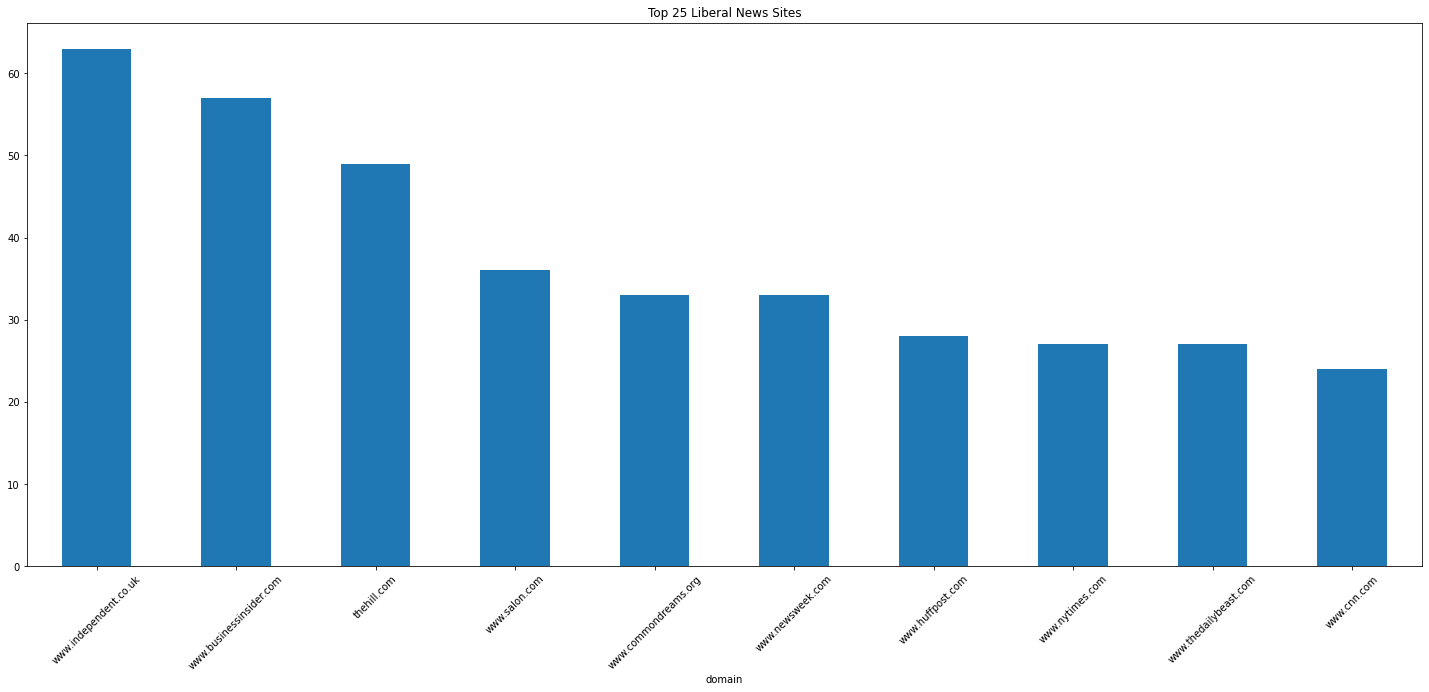

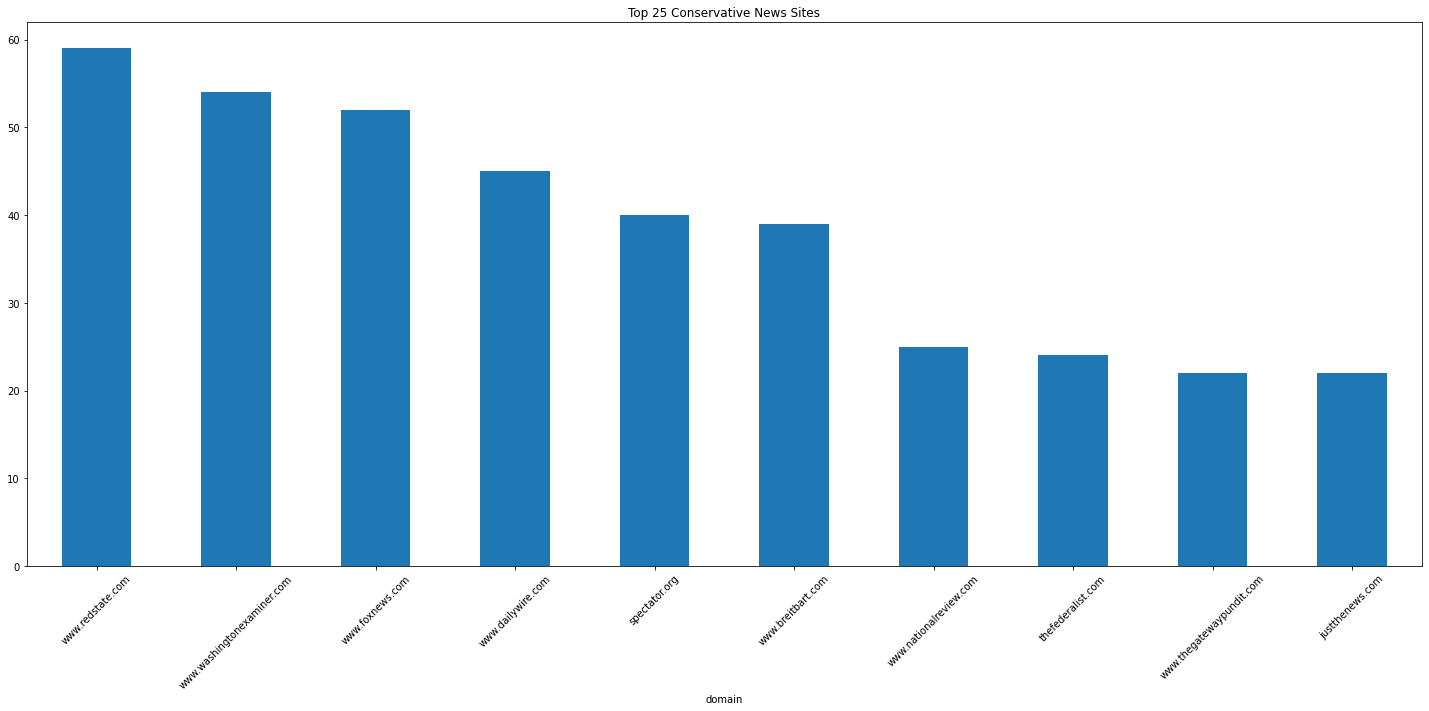

In [37]:
df = pd.DataFrame(result, columns=["total_count", "liberal_count", "conservative_count", "domain"])

df.sort_values('liberal_count', ascending=False)[:10].plot.bar(y=['liberal_count'], x='domain', figsize=(25,10), title="Top 25 Liberal News Sites", rot=45, legend=False)
df.sort_values('conservative_count', ascending=False)[:10].plot.bar(y=['conservative_count'], x='domain', figsize=(25,10), rot=45, title="Top 25 Conservative News Sites", legend=False)

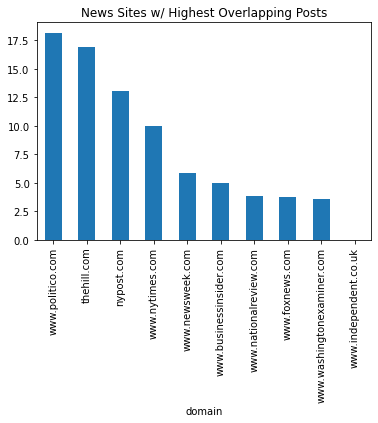

In [15]:
df['overlap'] = (df[['liberal_count','conservative_count']].min(axis=1) / df['total_count']) * 100
df = df[df['total_count'] > 20].sort_values('overlap', ascending=False)
df[:10].plot.bar(y='overlap', x='domain', title="News Sites w/ Highest Overlapping Posts", legend=False)

In [16]:
#Get the most common keywords of each news type
cur.execute("""
SELECT count(*), keyword
FROM articlekeywords
WHERE created_utc > extract(epoch from now() - interval '1 month')
GROUP BY keyword
ORDER BY count(*) DESC
LIMIT 25
""")
result = cur.fetchall()

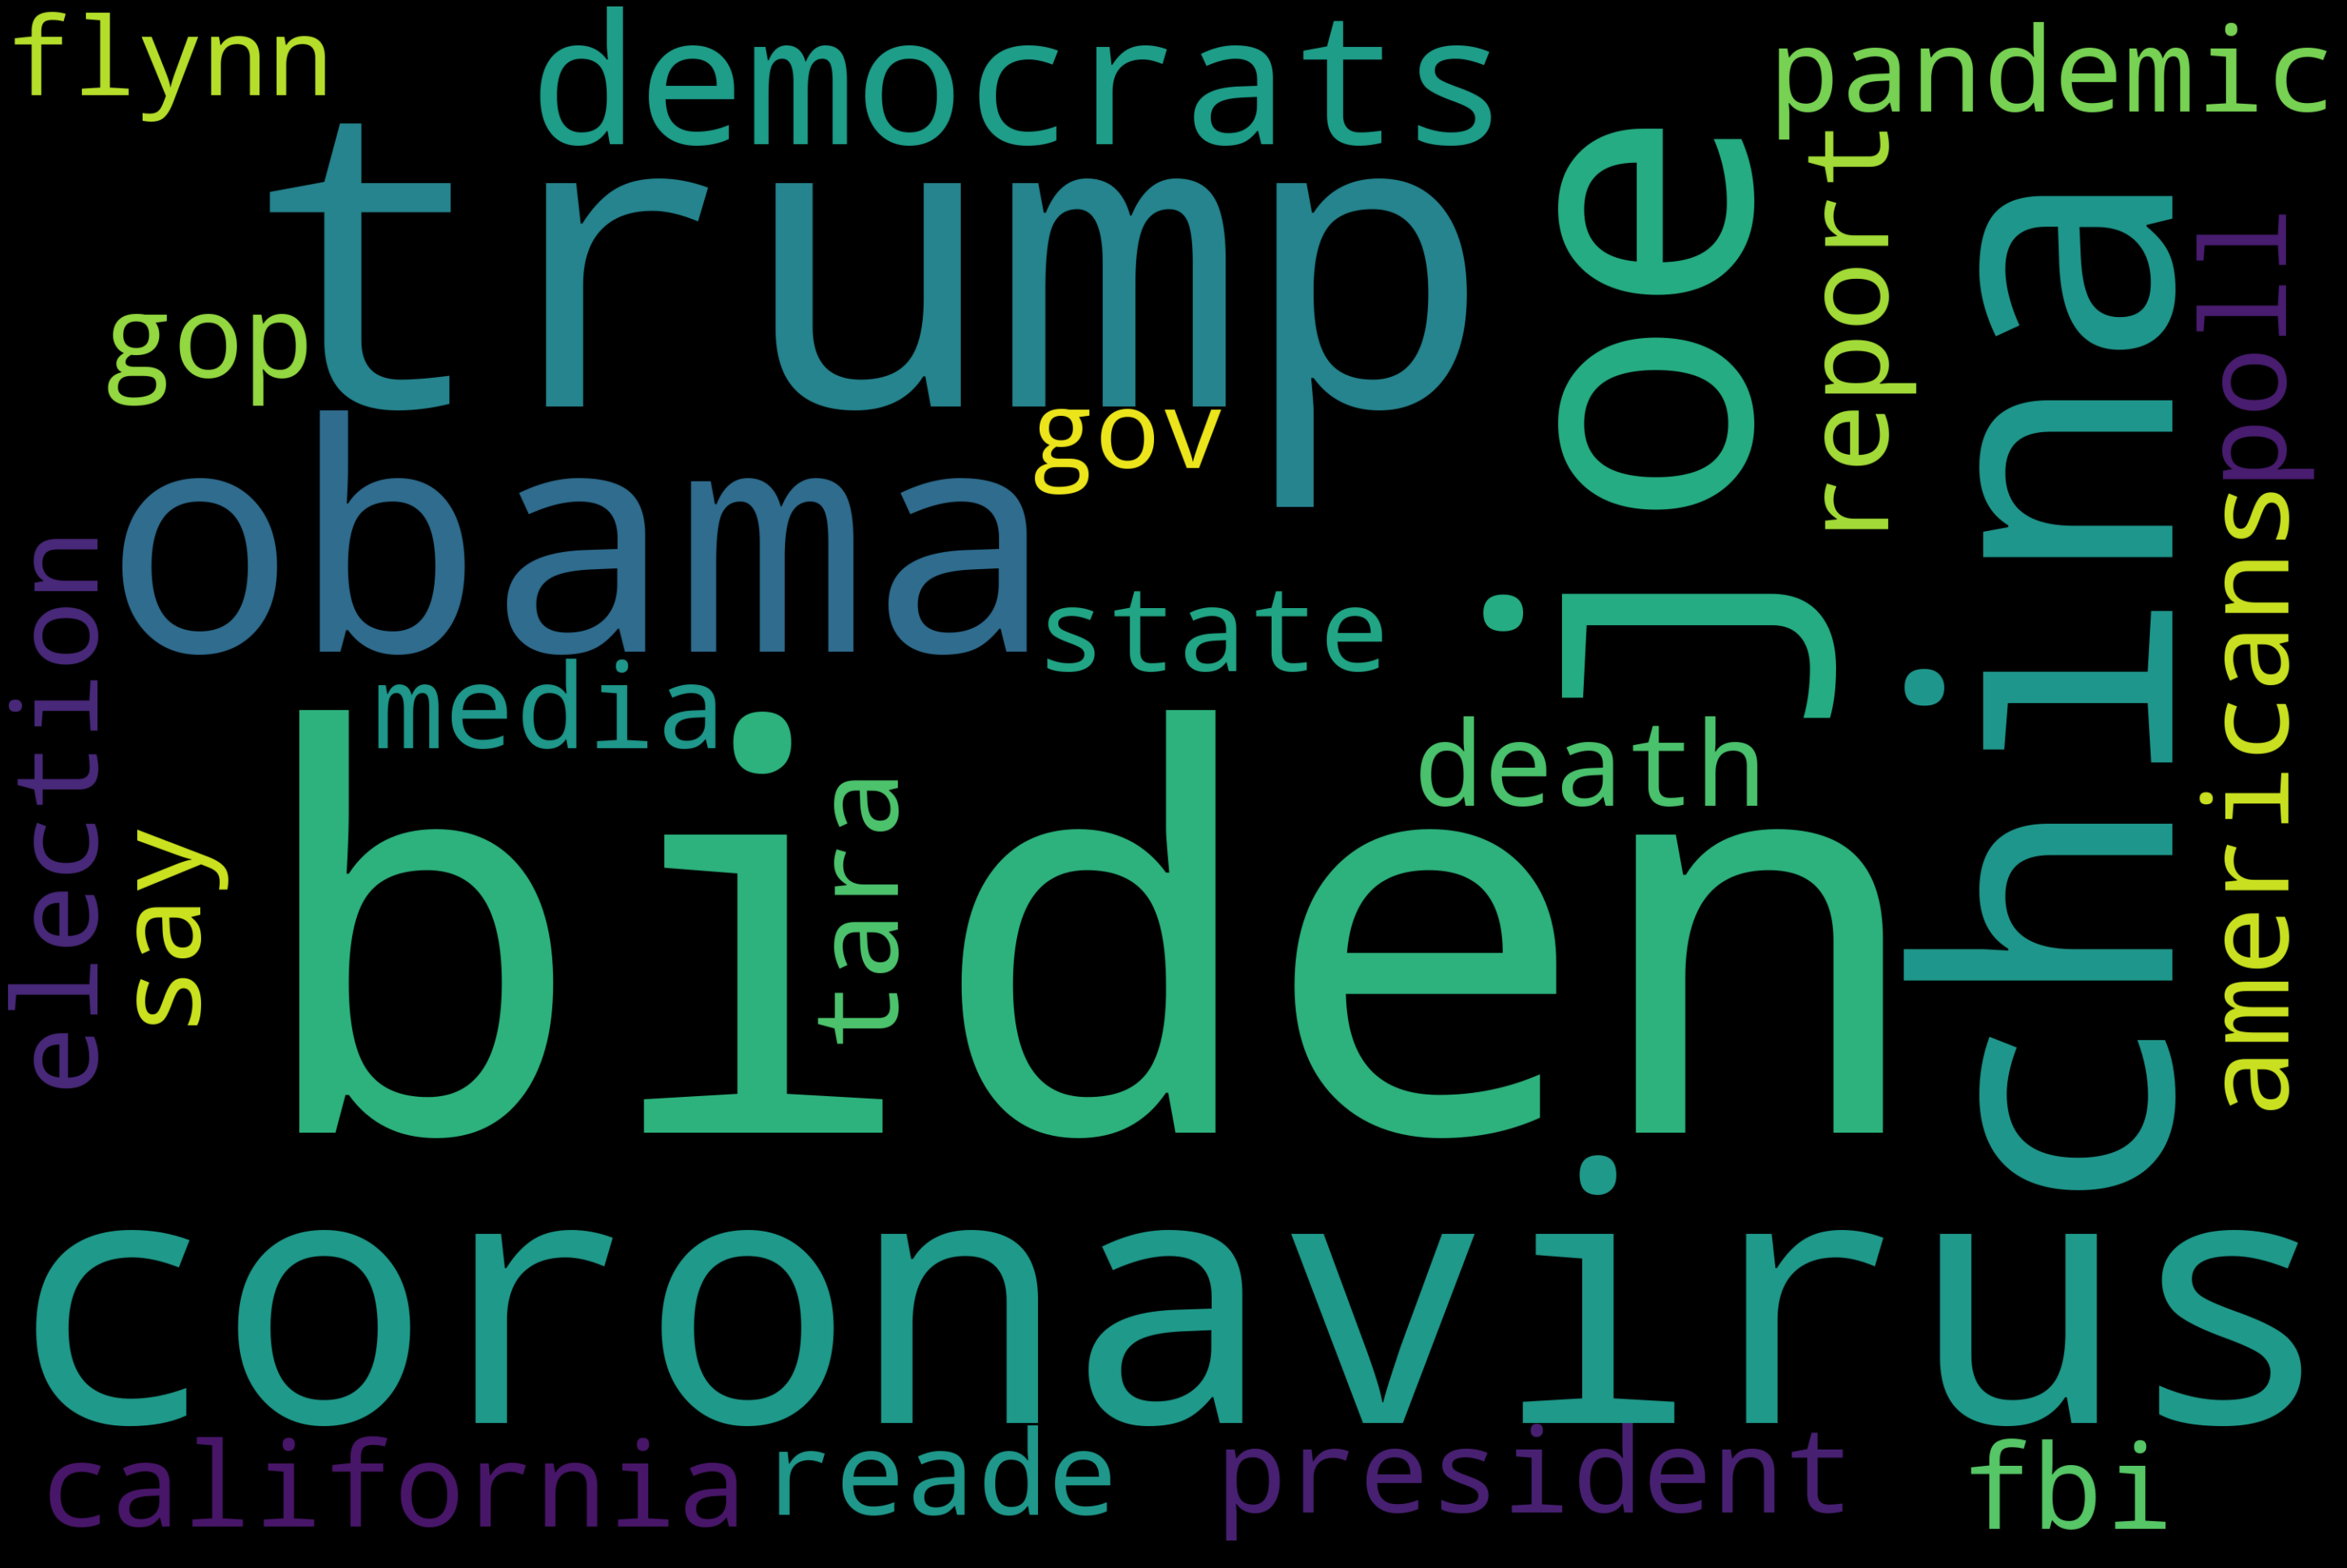

In [18]:
from wordcloud import WordCloud
df = pd.DataFrame(result, columns=['count', 'keyword'])
df['keyword'] = df['keyword'].apply(lambda x: x.replace("'", ""))

vals = df.keyword.values
text = ''
for v in vals:
    text += v + ' '

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

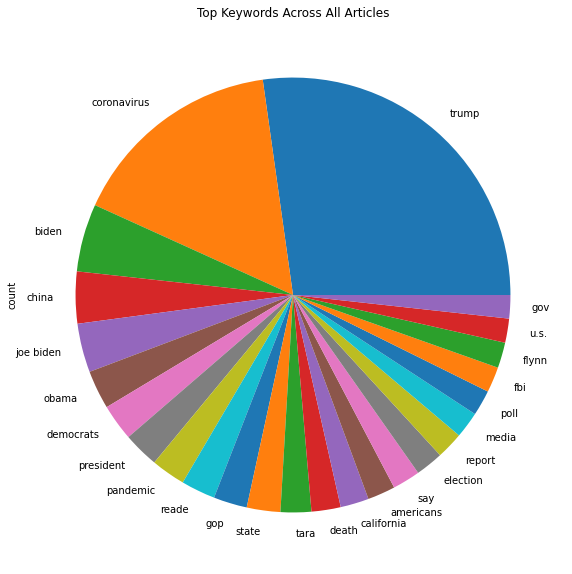

In [22]:
df.plot.pie(y='count', labels=df['keyword'], figsize=(25,10), legend=False, title="Top Keywords Across All Articles")

In [27]:
conn.rollback()